In [2]:
from getQuartets import *
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from matplotlib.legend import _get_legend_handles_labels

In [3]:
FACTORS = ["0.5", '1.0', '2.0', '4.0', '8.0']
POLYMORPHISM = ["low", "mod", "modhigh", "high", "veryhigh"]
num_taxa = 10
dataset_size = "small" if num_taxa == 10 else "big"
expected_replicas = 128 if num_taxa == 10 else 16 # trees * replicas per tree

if num_taxa == 10:
    FACTORS = ["0.5", '1.0', '2.0', '4.0', '8.0']
    POLYMORPHISM = ["low", "mod", "modhigh", "high", "veryhigh"]
    METHODS = ["ASTRAL(1,2)", "ASTRAL(3,2)", "MP4"]
else: 
    FACTORS = ['1.0', '2.0', '4.0', '8.0']
    POLYMORPHISM = ["mod", "modhigh", "high", "veryhigh"]
    METHODS = ["ASTRAL(1,2)", "ASTRAL(1,3)", "ASTRAL(1,5)", "ASTRAL(3,2)", "ASTRAL(3,3)", "ASTRAL(3,5)", "MP4"]

QT_NAMES = [
    'QT-ERROR-OFFBYONE',
    'OneMostProb',
    'AllMostProb',
    'MP4',
    'Loss-Rooted',
    'Loss-Unrooted'
]
BP_NAMES = [
    'BP-ERROR-OFFBYONE',
    'None-Exact',
    'None',
    'GA',
    'MP4',
    'GA+MP4'
]

In [4]:
name_re = re.compile(r'ASTRAL\((?P<qt>[0-9]),(?P<bp>[0-9])\)')
def get_name(method_name):
    m = name_re.match(method_name)
    if m is not None: 
        qt = QT_NAMES[int(m.group('qt'))]
        bp = BP_NAMES[int(m.group('bp'))]
        return f'ASTRAL({qt},{bp})'
    return method_name


In [5]:
def get_data(score_path, method=None, morph_desc: str = ""):
    data = {'score': [], 'polymorphism': [], 'factor': [], 'method': [], 'has_morph': []}
    with open(score_path) as file:
        lines = file.read().split('\n')
        N = len(lines)
        i = 0
        while i < N - 1:
            filename = lines[i]
            try:
                score = float(lines[i + 1].split()[1])        
            except:
                print(f"FAIL {score_path}: i={i + 1}, line={lines[i + 1]}")
                i += 1
                continue
            if(score < 0):
                print("Negative value: ", filename)
                i += 1
                continue
            data['score'].append(score * 100)
            data['method'].append(get_name(method))
            data['has_morph'].append(morph_desc)
            data['polymorphism'].append(
                re.search(
                    r'/simulated_data(\_small)?(-[0-9]\.[0-9])?/(?P<poly>\S+)_noborrowing',
                    filename
                ).group('poly')
            )
            data['factor'].append(
                re.search(
                    r'inference_outputs-(?P<factor>[0-9].[05])/',
                    score_path
                ).group('factor')
            )
            i += 2
            # print(s, score)
    n_ret = len(data["score"]) 
    if n_ret == expected_replicas:
        pass
        # print(f'✅︎✅︎✅︎ {len(data["score"])} items retrieved.')
    else:
        print(f'❗❗❗ {len(data["score"])} items retrieved.')
    return data


In [6]:
def get_data_as_dict(has_morph_ : bool): 
    data = {
        'score': [],
        'polymorphism': [],
        'method': [],
        'factor': [],
        'summary': [],
        'has_morph': []
    }
    if has_morph_:
        folder = 'outputs_with_morph'
        morph_desc = 'With morphological characters'
    else:
        folder = 'outputs_no_morph'
        morph_desc = 'Without morphological characters'
    for factor in FACTORS:
        for m in METHODS:
            for p in POLYMORPHISM:
                data_ = get_data(f"../outputs_{dataset_size}/{folder}/inference_outputs-{factor}/{p}_noborrowing/{m}/allscores.txt", m, morph_desc=morph_desc)
                data['score'] += data_['score']
                data['polymorphism'] += data_['polymorphism']
                data['method'] += data_['method']
                data['factor'] += data_['factor']
                data['has_morph'] += data_['has_morph']
                data['summary'] += [f'{"T" if has_morph_ else "F"}-{factor}-{m}-{p}'] * len(data_['method'])
    print(data)
    return data
           

In [7]:
data_nomorph = get_data_as_dict(True)
data_morph = get_data_as_dict(False)

FAIL ../outputs_small/outputs_with_morph/inference_outputs-0.5/low_noborrowing/ASTRAL(3,2)/allscores.txt: i=37, line=./QuartetMethods/example/simulated_data_small-0.5/low_noborrowing//sim_tree5_4.csv
FAIL ../outputs_small/outputs_with_morph/inference_outputs-0.5/low_noborrowing/ASTRAL(3,2)/allscores.txt: i=48, line=./QuartetMethods/example/simulated_data_small-0.5/low_noborrowing//sim_tree7_2.csv
FAIL ../outputs_small/outputs_with_morph/inference_outputs-0.5/low_noborrowing/ASTRAL(3,2)/allscores.txt: i=63, line=./QuartetMethods/example/simulated_data_small-0.5/low_noborrowing//sim_tree9_2.csv
FAIL ../outputs_small/outputs_with_morph/inference_outputs-0.5/low_noborrowing/ASTRAL(3,2)/allscores.txt: i=64, line=./QuartetMethods/example/simulated_data_small-0.5/low_noborrowing//sim_tree9_3.csv
FAIL ../outputs_small/outputs_with_morph/inference_outputs-0.5/low_noborrowing/ASTRAL(3,2)/allscores.txt: i=65, line=./QuartetMethods/example/simulated_data_small-0.5/low_noborrowing//sim_tree9_4.csv


In [8]:
def merge_datas(A, B):
    for x, t in A.items():
        B[x] += t
        print(x)
    return B

def check_dataset(A):
    for x in A:
        print(x, len(A[x]))

In [9]:
check_dataset(data_morph)

score 9526
polymorphism 9526
method 9526
factor 9526
summary 9526
has_morph 9526


In [10]:
print(len(data_nomorph['factor']),len(data_morph['factor']))

9528 9526


In [11]:
data = merge_datas(data_morph, data_nomorph)
df = pd.DataFrame(data)
df_morph = pd.DataFrame(data_morph)
df_nomorph = pd.DataFrame(data_nomorph)

score
polymorphism
method
factor
summary
has_morph


In [12]:
df_morph.head()

,score,polymorphism,method,factor,summary,has_morph
0,14.285714,low,"ASTRAL(OneMostProb,None)",0.5,"F-0.5-ASTRAL(1,2)-low",Without morphological characters
1,0.000000,low,"ASTRAL(OneMostProb,None)",0.5,"F-0.5-ASTRAL(1,2)-low",Without morphological characters
2,0.000000,low,"ASTRAL(OneMostProb,None)",0.5,"F-0.5-ASTRAL(1,2)-low",Without morphological characters
3,0.000000,low,"ASTRAL(OneMostProb,None)",0.5,"F-0.5-ASTRAL(1,2)-low",Without morphological characters
4,0.000000,low,"ASTRAL(OneMostProb,None)",0.5,"F-0.5-ASTRAL(1,2)-low",Without morphological characters


In [13]:
df_morph.dtypes

score           float64
polymorphism     object
method           object
factor           object
summary          object
has_morph        object
dtype: object

In [14]:
qt_criterion = lambda k, df: df["method"].map(
    lambda x: 
        x.startswith(f"ASTRAL({QT_NAMES[k]},") or x == "MP4" or num_taxa == 10
)

bp_criterion = lambda k, df: df["method"].map(
    lambda x: 
        x.endswith(f",{BP_NAMES[k]})") or x == "MP4" or num_taxa == 10
)

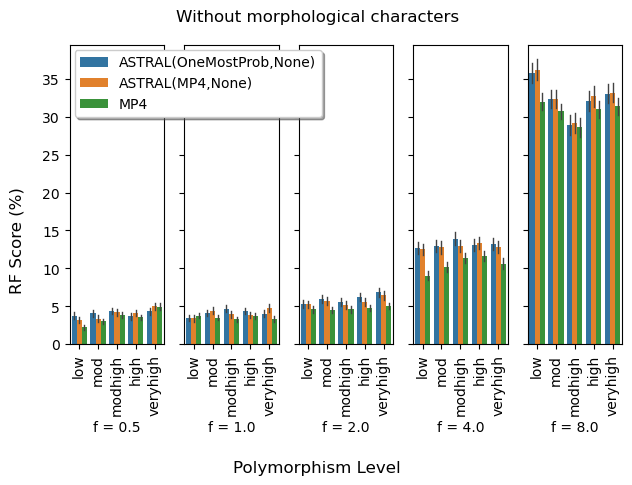

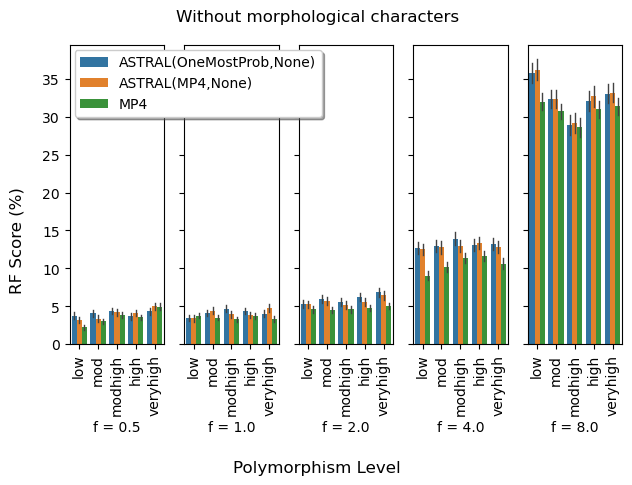

In [15]:
for qt in [1, 3]:
    fig, axes = plt.subplots(1, int(len(FACTORS)), sharey=True)
    fig.suptitle(f"Without morphological characters, Quartet method = {QT_NAMES[qt]}")
    if num_taxa == 10:
        fig.suptitle(f"Without morphological characters")
    fig.supylabel("RF Score (%)")
    fig.supxlabel("Polymorphism Level")
    loc, labels = plt.xticks()
    for factor, ax in zip(FACTORS, axes):
        sns.barplot(ax=ax, data=df_nomorph[(df_nomorph["factor"] == factor) & qt_criterion(qt, df_nomorph)], x='polymorphism', y='score', hue='method', errorbar='se', errwidth=1.0)
        ax.get_legend().remove()
        ax.set_xlabel(f"f = {factor}")
        ax.set_ylabel("")
        ax.tick_params(axis='x', rotation=90)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.11, 0.91),
          ncol=1, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(f"../figs/{num_taxa}-method-no-{QT_NAMES[qt]}")

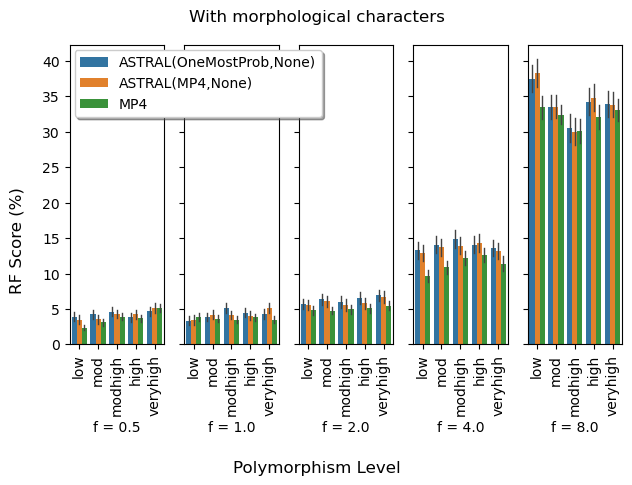

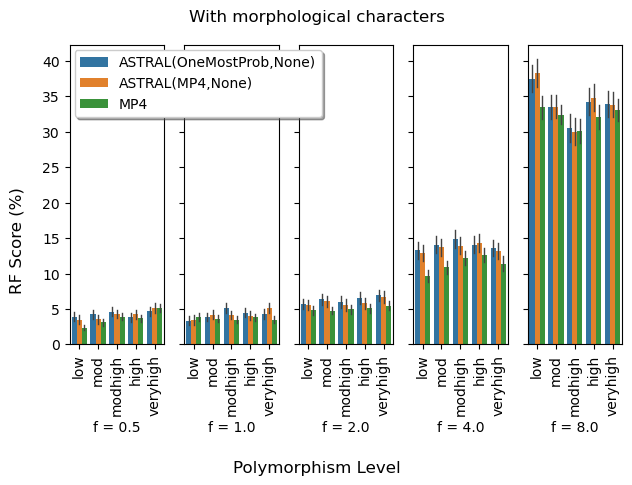

In [16]:
for qt in [1, 3]:
    fig, axes = plt.subplots(1, int(len(FACTORS)), sharey=True)
    fig.suptitle(f"With morphological characters, Quartet Method = {QT_NAMES[qt]}")
    if num_taxa == 10:
        fig.suptitle(f"With morphological characters")
    fig.supylabel("RF Score (%)")
    fig.supxlabel("Polymorphism Level")
    loc, labels = plt.xticks()
    for file, ax in zip(FACTORS, axes):
        sns.barplot(ax=ax, data=df_morph[(df_morph["factor"] == file) & qt_criterion(qt, df_morph)], x='polymorphism', y='score', hue='method', errorbar='se', errwidth=1)
        ax.get_legend().remove()
        ax.set_xlabel(f"f = {file}")
        ax.set_ylabel("")
        ax.tick_params(axis='x', rotation=90)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.11, 0.91),
          ncol=1, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(f"../figs/{num_taxa}-method-with-{QT_NAMES[qt]}")

In [17]:
no_morph_errors = df_nomorph.groupby(["factor", "method", "polymorphism"])["score"].aggregate("mean")
no_morph_errors_np = np.array(no_morph_errors)
morph_errors = df_morph.groupby(["factor", "method", "polymorphism"])["score"].aggregate("mean")
morph_errors_np = np.array(morph_errors)
morph_advantage = no_morph_errors - morph_errors

In [18]:
from matplotlib.legend import _get_legend_handles_labels


def get_graph_for_method(target_method):

    fig, axes = plt.subplots(1, int(len(FACTORS)), sharey=True)

    fig.suptitle(target_method)
    fig.supylabel("RF Score (%)")
    loc, labels = plt.xticks()
    df_ = df[df["method"] == target_method]
    for f, ax in zip(FACTORS, axes):
        sns.barplot(ax=ax, data=df_[df_["factor"] == f], x='polymorphism', y='score', hue='has_morph', errorbar='se', errwidth=1.0)
        ax.get_legend().remove()
        ax.set_xlabel(f"f = {f}")
        ax.set_ylabel("")
        ax.tick_params(axis='x', rotation=90)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.11, 0.91),
          ncol=1, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.savefig(f"../figs/{num_taxa}-morph-{target_method.lower()}")

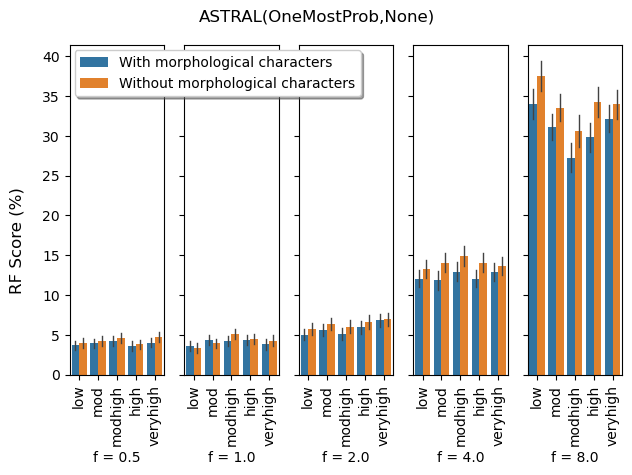

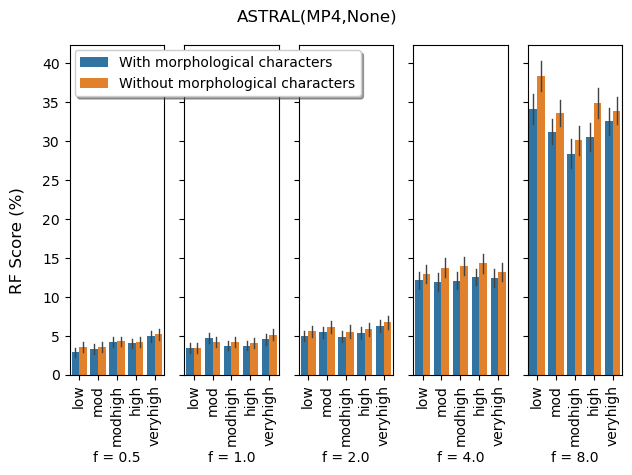

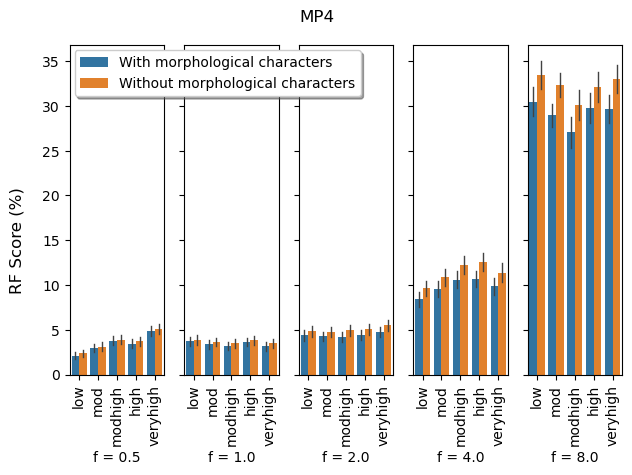

In [19]:
for target_method in METHODS:
    get_graph_for_method(get_name(target_method))

In [20]:
df_ = df[df["method"] == "ASTRAL"]
data=df_[df_["factor"] == file]
data

,score,polymorphism,method,factor,summary,has_morph
